# Segmentation of Figure 8

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage import io, color, filters, measure, morphology, segmentation
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

(np.float64(-0.5), np.float64(747.5), np.float64(555.5), np.float64(-0.5))

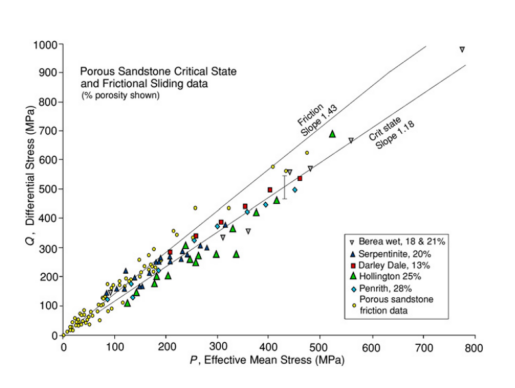

In [2]:
# Load Figure 8 graph
image = cv2.imread('figure/fig8.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_rgb)
plt.axis('off')

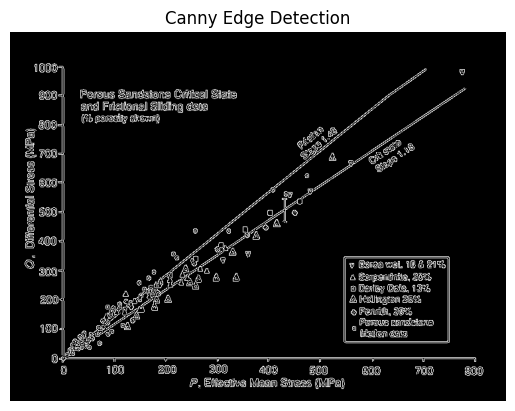

In [3]:
# Edge detection using Canny method
edges = cv2.Canny(grayscale_image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

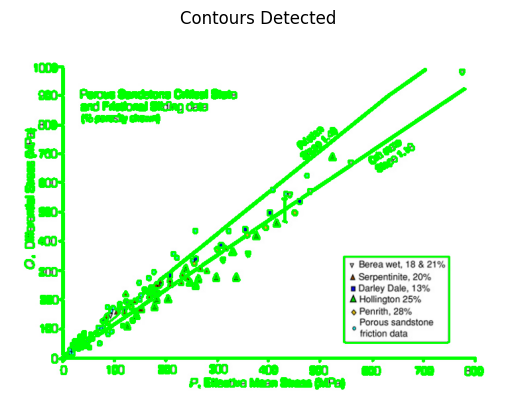

In [4]:
# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours on the original image
contour_image = image.copy()
for contour in contours:
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
plt.imshow(contour_image)
plt.title('Contours Detected')
plt.axis('off')
plt.show()

In [5]:
# Calculate areas of all contours
areas = [cv2.contourArea(c) for c in contours]
# print the areas of the contours
print(f"Number of contours: {len(areas)}")
print(f"Min area: {min(areas) if areas else 0}")
print(f"Max area: {max(areas) if areas else 0}")
print(f"Mean area: {np.mean(areas) if areas else 0}")
print(f"Median area: {np.median(areas) if areas else 0}")

Number of contours: 306
Min area: 0.0
Max area: 20663.5
Mean area: 108.41830065359477
Median area: 14.75


In [6]:
# Pair each contour with its area
contour_area_pairs = list(zip(contours, areas))
# Sort by area, descending
contour_area_pairs.sort(key=lambda x: x[1], reverse=True)

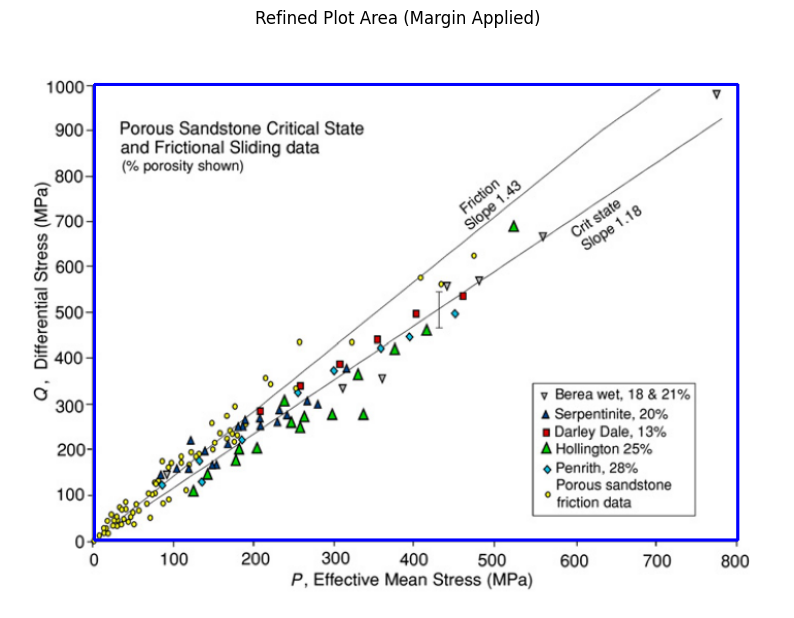

In [7]:
# Identifying the Plot Area
# Use Canny edge detection
edges = cv2.Canny(grayscale_image, 50, 150)

margin = 15  # You can adjust this value as needed

# Use Hough Line Transform to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

# Find the extreme lines (leftmost, rightmost, topmost, bottommost)
x_min, x_max, y_min, y_max = image.shape[1], 0, image.shape[0], 0
for line in lines:
    x1, y1, x2, y2 = line[0]
    x_min = min(x_min, x1, x2)
    x_max = max(x_max, x1, x2)
    y_min = min(y_min, y1, y2)
    y_max = max(y_max, y1, y2)

# Refine the bounding box: move left and bottom sides inward by margin
plot_left   = min(x_min + margin + 3, image.shape[1] - 1)
plot_right  = max(x_max, 0)
plot_top    = min(y_min, image.shape[0] - 1)
plot_bottom = max(y_max - margin - 30, 0)

# Ensure coordinates are within image bounds
plot_left   = max(plot_left, 0)
plot_right  = min(plot_right, image.shape[1] - 1)
plot_top    = max(plot_top, 0)
plot_bottom = min(plot_bottom, image.shape[0] - 1)

# Draw the refined plot area
plot_area_img = image.copy()
cv2.rectangle(plot_area_img, (plot_left, plot_top), (plot_right, plot_bottom), (255, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(plot_area_img, cv2.COLOR_BGR2RGB))
plt.title('Refined Plot Area (Margin Applied)')
plt.axis('off')
plt.show()

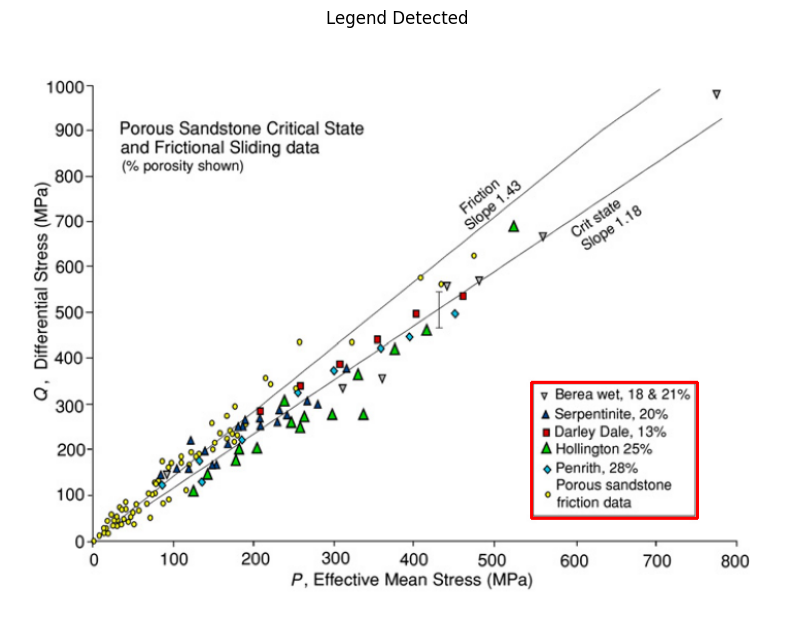

In [8]:
# Identifying the Legend Area
legend_candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0
    # Heuristic: legend is in the right 1/3 and lower 1/2 of the image, and is a medium-large box
    if (x > image.shape[1] * 0.6 and y > image.shape[0] * 0.5 and
        area > 1000 and area < 0.2 * image.shape[0] * image.shape[1] and
        0.7 < aspect_ratio < 2.5):
        legend_candidates.append((x, y, w, h))

# Draw the legend box
legend_img = image.copy()
for (x, y, w, h) in legend_candidates:
    cv2.rectangle(legend_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
plt.title('Legend Detected')
plt.axis('off')
plt.show()

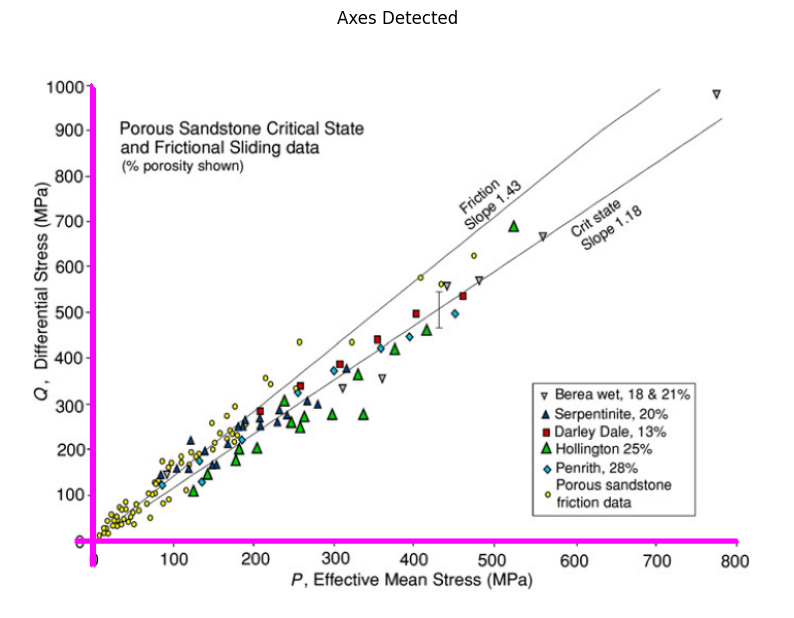

In [9]:
# Identifying the Axes
axes_img = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    # Vertical (y-axis)
    if abs(x1 - x2) < 10 and abs(y1 - y2) > image.shape[0] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)
    # Horizontal (x-axis)
    if abs(y1 - y2) < 10 and abs(x1 - x2) > image.shape[1] * 0.7:
        cv2.line(axes_img, (x1, y1), (x2, y2), (255, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(axes_img, cv2.COLOR_BGR2RGB))
plt.title('Axes Detected')
plt.axis('off')
plt.show()

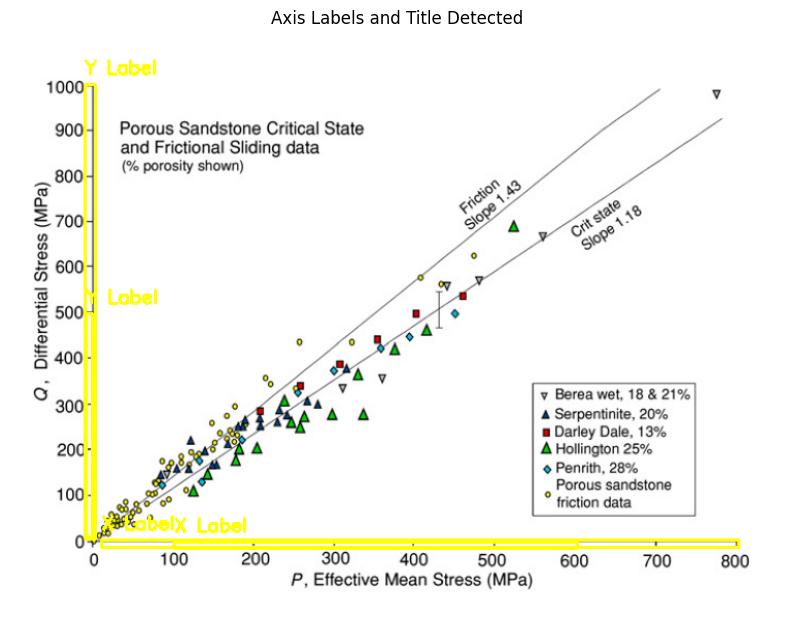

In [10]:
label_candidates = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    aspect_ratio = w / h if h != 0 else 0
    # Title: top 1/4, wide, not too tall
    if y < image.shape[0] * 0.25 and w > image.shape[1] * 0.3 and h < image.shape[0] * 0.1:
        label_candidates.append(('Title', x, y, w, h))
    # X-axis label: bottom 1/4, wide, not too tall
    elif y > image.shape[0] * 0.75 and w > image.shape[1] * 0.3 and h < image.shape[0] * 0.1:
        label_candidates.append(('X Label', x, y, w, h))
    # Y-axis label: left 1/4, tall, not too wide
    elif x < image.shape[1] * 0.25 and h > image.shape[0] * 0.3 and w < image.shape[1] * 0.1:
        label_candidates.append(('Y Label', x, y, w, h))

# Draw the labels
labels_img = image.copy()
for (label, x, y, w, h) in label_candidates:
    cv2.rectangle(labels_img, (x, y), (x + w, y + h), (0, 255, 255), 2)
    cv2.putText(labels_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(labels_img, cv2.COLOR_BGR2RGB))
plt.title('Axis Labels and Title Detected')
plt.axis('off')
plt.show()

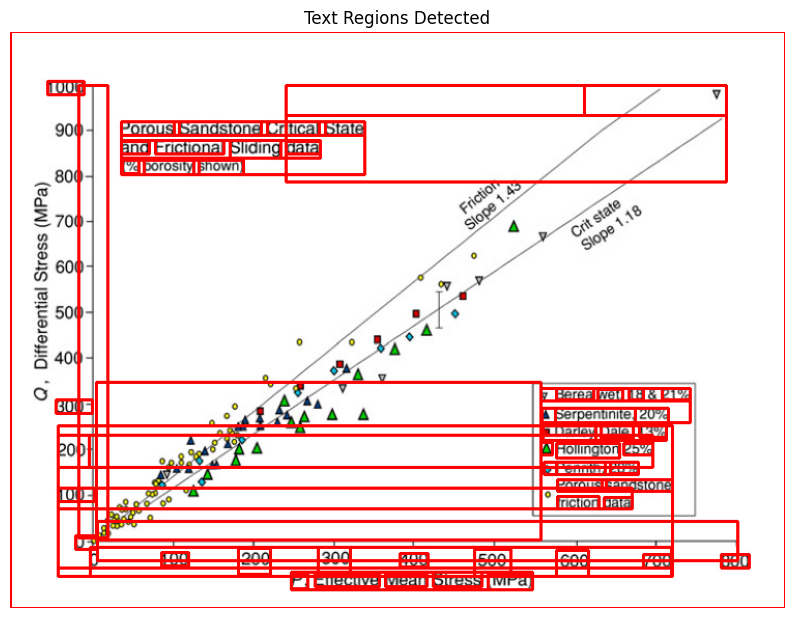

In [11]:
import pytesseract
from pytesseract import Output

# Convert image to RGB if needed
rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run OCR
d = pytesseract.image_to_data(rgb_img, output_type=Output.DICT)

# Draw boxes around detected text
for i in range(len(d['level'])):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    if w > 10 and h > 10:  # Filter out very small boxes
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Text Regions Detected')
plt.axis('off')
plt.show()

## Extract Text from Plot Regions
Extract text from title, legend, and axes labels using OCR

In [14]:
# Helper function to extract text from image region
def extract_text_from_region(img, x, y, w, h):
    region = img[y:y+h, x:x+w]
    text = pytesseract.image_to_string(region).strip()
    return text

# Extract plot title (top 15% of image)
title_height = int(image.shape[0] * 0.15)
title_text = extract_text_from_region(rgb_img, 0, 0, image.shape[1], title_height)
print('Title:', title_text)

# Extract legend text (using detected legend box)
if legend_candidates:
    x, y, w, h = legend_candidates[0]
    legend_text = extract_text_from_region(rgb_img, x, y, w, h)
    print('\nLegend:')
    print(legend_text)

# Extract axis labels
for label_type, x, y, w, h in label_candidates:
    text = extract_text_from_region(rgb_img, x, y, w, h)
    print(f'\n{label_type}:', text)

Title: 10005

Legend:
v Berea wet, 18 & 21%

A Serpentinite, 20%

1 Darley Dale, 13%

‘A Hollington 25%

© Penrith, 28%

«, Porous sandstone
friction data

Legend:
v Berea wet, 18 & 21%

A Serpentinite, 20%

1 Darley Dale, 13%

‘A Hollington 25%

© Penrith, 28%

«, Porous sandstone
friction data

X Label: 

X Label: 

X Label: 

X Label: 

Y Label: 

Y Label: 

Y Label: 

Y Label: 


In [15]:
# Extract axis scale values
def extract_axis_values(img, plot_left, plot_right, plot_top, plot_bottom, margin=5):
    # X-axis values (bottom)
    x_scale_region = img[plot_bottom+margin:plot_bottom+30, plot_left:plot_right]
    x_values = pytesseract.image_to_string(x_scale_region, config='--psm 6').strip()

    # Y-axis values (left)
    y_scale_region = img[plot_top:plot_bottom, max(0, plot_left-50):plot_left-margin]
    y_values = pytesseract.image_to_string(y_scale_region, config='--psm 6').strip()
    
    return x_values, y_values

x_scale, y_scale = extract_axis_values(rgb_img, plot_left, plot_right, plot_top, plot_bottom)
print('X-axis scale values:', x_scale)
print('Y-axis scale values:', y_scale)

X-axis scale values: ) 100 200 300 400 500 600 700 8c
Y-axis scale values: =
900.

_ 800:

;

= 700

3

5 600

= 500:

D

| 400-

* 300:
200
100


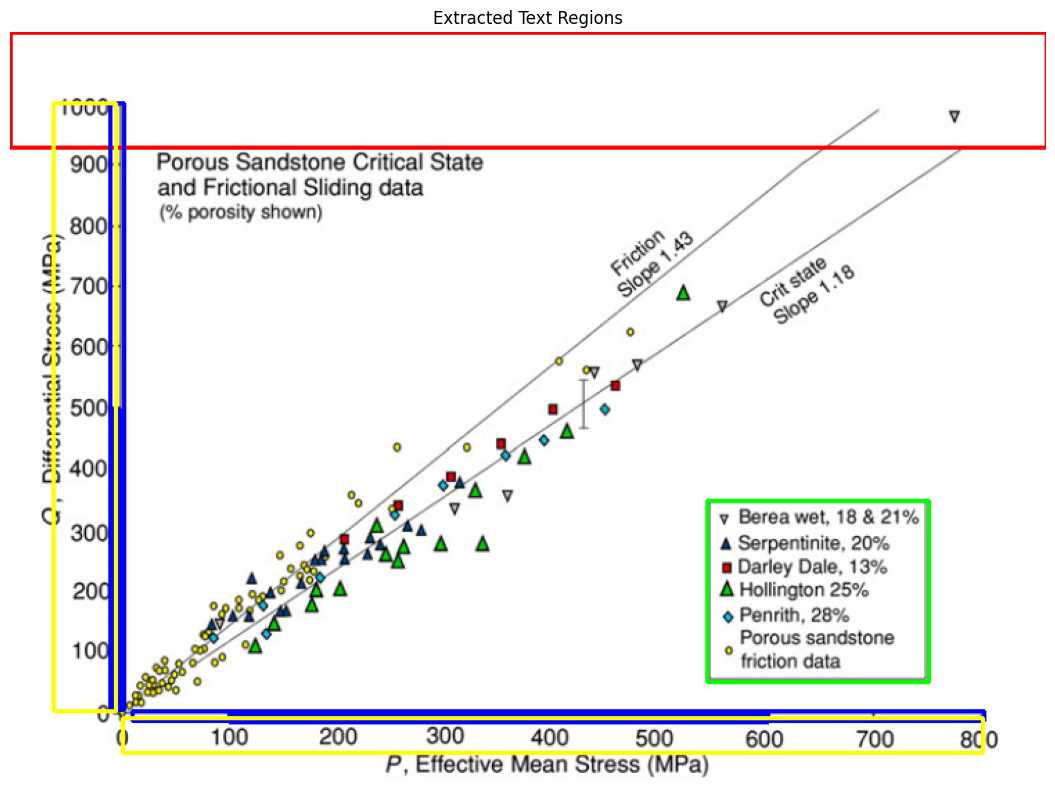

In [16]:
# Visualize the extracted regions
vis_img = rgb_img.copy()

# Draw title region
cv2.rectangle(vis_img, (0, 0), (image.shape[1], title_height), (255, 0, 0), 2)

# Draw legend box
if legend_candidates:
    x, y, w, h = legend_candidates[0]
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Draw axis label regions
for label_type, x, y, w, h in label_candidates:
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Draw scale regions
cv2.rectangle(vis_img, 
            (plot_left, plot_bottom+5), 
            (plot_right, plot_bottom+30), 
            (255, 255, 0), 2)
cv2.rectangle(vis_img, 
            (max(0, plot_left-50), plot_top), 
            (plot_left-5, plot_bottom), 
            (255, 255, 0), 2)

plt.figure(figsize=(15, 10))
plt.imshow(vis_img)
plt.title('Extracted Text Regions')
plt.axis('off')
plt.show()